In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, Concatenate, Dropout

In [2]:
df=pd.read_csv("/kaggle/input/cleaned-dataset/data_processed.csv")

In [3]:
# Codificamos userId y productId
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

df['userId_encoded'] = user_encoder.fit_transform(df['productId'])  # Usamos productId como usuario ficticio
df['productId_encoded'] = product_encoder.fit_transform(df['productId'])

# División en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Parámetros del modelo
num_users = df['userId_encoded'].nunique()
num_products = df['productId_encoded'].nunique()
embedding_size = 50  # Tamaño del embedding


In [8]:
def build_nn_model(embedding_size=50, dropout_rate=0.3):
    user_input = Input(shape=(1,))
    product_input = Input(shape=(1,))

    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size)(user_input)
    product_embedding = Embedding(input_dim=num_products, output_dim=embedding_size)(product_input)

    user_vector = Flatten()(user_embedding)
    product_vector = Flatten()(product_embedding)

    concat = Concatenate()([user_vector, product_vector])

    dense = Dense(128, activation='relu')(concat)
    dense = Dropout(dropout_rate)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    output = Dense(1, activation='linear')(dense)  # Predicción de rating

    model = Model(inputs=[user_input, product_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Construimos el modelo
nn_model = build_nn_model()
nn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1, 50)          │     19,810,500 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 1, 50)          │     19,810,500 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 50)             │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 50)             │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 100)            │              0 │ flatten_4[0][0],       │
│ (Concatenate)             │                        │                │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │         12,928 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │          8,256 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64)             │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1)              │             65 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,642,249 (151.22 MB)

 Trainable params: 39,642,249 (151.22 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = nn_model.fit(
    [train_data['userId_encoded'], train_data['productId_encoded']],
    train_data['ratings'],
    validation_data=([test_data['userId_encoded'], test_data['productId_encoded']], test_data['ratings']),
    epochs=50, batch_size=128, verbose=1
)


Epoch 1/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1.5590 - mae: 0.8433 - val_loss: 0.4013 - val_mae: 0.4063
Epoch 2/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.4865 - mae: 0.5157 - val_loss: 0.3899 - val_mae: 0.4043
Epoch 3/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.2975 - mae: 0.3977 - val_loss: 0.3738 - val_mae: 0.3817
Epoch 4/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.1615 - mae: 0.2798 - val_loss: 0.3684 - val_mae: 0.3710
Epoch 5/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.1021 - mae: 0.2082 - val_loss: 0.3644 - val_mae: 0.3615
Epoch 6/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0822 - mae: 0.1723 - val_loss: 0.3617 - val_mae: 0.3517
Epoch 7/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0724 - mae: 0.1560 - val_loss: 0.3612 - val_mae: 0.3480
Epoch 8/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0691 - mae: 0.1458 - val_loss: 0.3613 - val_mae: 0.3462
Epoch 9/50
2821/2821 ━━━━━━━━━━━

In [4]:
# Definición de modelo más profundo
def build_deep_nn_model(embedding_size=50, dropout_rate=0.3):
    user_input = Input(shape=(1,))
    product_input = Input(shape=(1,))
    
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size)(user_input)
    product_embedding = Embedding(input_dim=num_products, output_dim=embedding_size)(product_input)
    
    user_vector = Flatten()(user_embedding)
    product_vector = Flatten()(product_embedding)
    
    concat = Concatenate()([user_vector, product_vector])
    
    dense = Dense(256, activation='relu')(concat)
    dense = Dropout(dropout_rate)(dense)
    dense = Dense(128, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    output = Dense(1, activation='linear')(dense)

    model = Model(inputs=[user_input, product_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

deep_nn_model = build_deep_nn_model()
deep_nn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 50)          │     19,810,500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 50)          │     19,810,500 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50)             │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 50)             │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 100)            │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         25,856 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,688,073 (151.40 MB)

 Trainable params: 39,688,073 (151.40 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history_deep = deep_nn_model.fit(
    [train_data['userId_encoded'], train_data['productId_encoded']], 
    train_data['ratings'], 
    validation_data=([test_data['userId_encoded'], test_data['productId_encoded']], test_data['ratings']),
    epochs=50, batch_size=128, verbose=1
)

Epoch 1/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 1.2393 - mae: 0.7659 - val_loss: 0.4102 - val_mae: 0.4287
Epoch 2/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.4613 - mae: 0.4993 - val_loss: 0.4104 - val_mae: 0.4363
Epoch 3/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.2881 - mae: 0.3872 - val_loss: 0.3804 - val_mae: 0.3992
Epoch 4/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.1660 - mae: 0.2829 - val_loss: 0.3718 - val_mae: 0.3797
Epoch 5/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.1031 - mae: 0.2078 - val_loss: 0.3677 - val_mae: 0.3650
Epoch 6/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0810 - mae: 0.1694 - val_loss: 0.3640 - val_mae: 0.3532
Epoch 7/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0720 - mae: 0.1517 - val_loss: 0.3661 - val_mae: 0.3543
Epoch 8/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0660 - mae: 0.1403 - val_loss: 0.3635 - val_mae: 0.3489
Epoch 9/50
2821/2821 ━━━━━━━━━━━

In [6]:
#modelo basado en autoencoders
def build_autoencoder(embedding_size=50, dropout_rate=0.3):
    user_input = Input(shape=(1,))
    product_input = Input(shape=(1,))
    
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size)(user_input)
    product_embedding = Embedding(input_dim=num_products, output_dim=embedding_size)(product_input)
    
    user_vector = Flatten()(user_embedding)
    product_vector = Flatten()(product_embedding)
    
    concat = Concatenate()([user_vector, product_vector])
    
    encoder = Dense(128, activation='relu')(concat)
    encoder = Dropout(dropout_rate)(encoder)
    encoder = Dense(64, activation='relu')(encoder)
    
    decoder = Dense(128, activation='relu')(encoder)
    decoder = Dropout(dropout_rate)(decoder)
    output = Dense(1, activation='linear')(decoder)

    model = Model(inputs=[user_input, product_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

autoencoder_model = build_autoencoder()
autoencoder_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 50)          │     19,810,500 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 50)          │     19,810,500 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 50)             │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 50)             │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 100)            │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         12,928 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │          8,320 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │            129 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,650,633 (151.26 MB)

 Trainable params: 39,650,633 (151.26 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history_autoencoder = autoencoder_model.fit(
    [train_data['userId_encoded'], train_data['productId_encoded']], 
    train_data['ratings'], 
    validation_data=([test_data['userId_encoded'], test_data['productId_encoded']], test_data['ratings']),
    epochs=50, batch_size=128, verbose=1
)


Epoch 1/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 1.1857 - mae: 0.7038 - val_loss: 0.3978 - val_mae: 0.4010
Epoch 2/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.4041 - mae: 0.4591 - val_loss: 0.3988 - val_mae: 0.4174
Epoch 3/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.2727 - mae: 0.3759 - val_loss: 0.3765 - val_mae: 0.3877
Epoch 4/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.1686 - mae: 0.2930 - val_loss: 0.3743 - val_mae: 0.3843
Epoch 5/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.1087 - mae: 0.2266 - val_loss: 0.3672 - val_mae: 0.3608
Epoch 6/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0813 - mae: 0.1805 - val_loss: 0.3645 - val_mae: 0.3566
Epoch 7/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0682 - mae: 0.1537 - val_loss: 0.3630 - val_mae: 0.3486
Epoch 8/50
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0614 - mae: 0.1363 - val_loss: 0.3611 - val_mae: 0.3437
Epoch 9/50
2821/2821 ━━━━━━━━━━━

In [10]:
# Guardar los modelos en formato .h5
nn_model.save("modelo_nn_simple.h5")
deep_nn_model.save("modelo_nn_profundo.h5")
autoencoder_model.save("modelo_autoencoder.h5")

print("Modelos guardados exitosamente.")


Modelos guardados exitosamente.


**Comparación de Resultados**

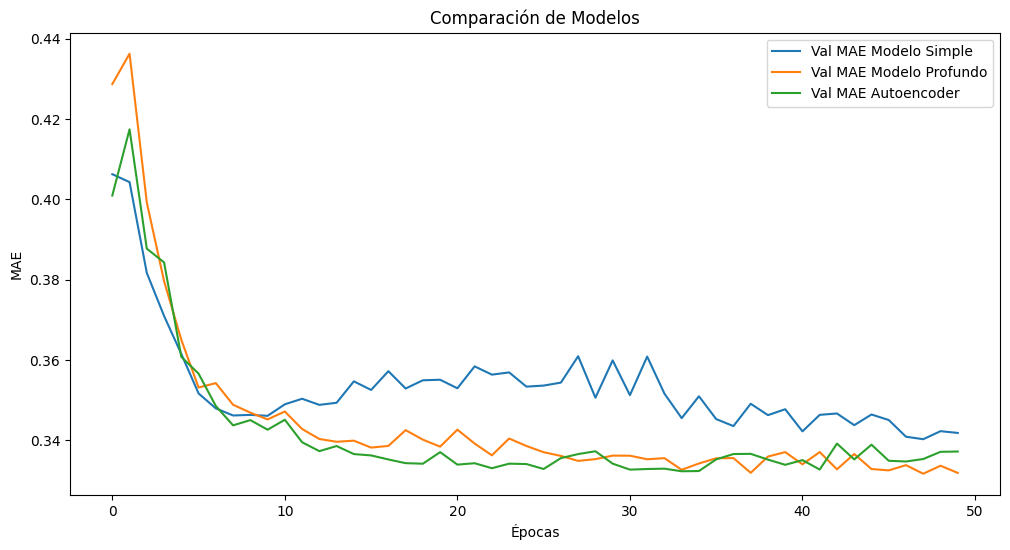

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(histories, labels):
    plt.figure(figsize=(12,6))
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_mae'], label=f'Val MAE {label}')
    plt.title('Comparación de Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

plot_training_history(
    [history, history_deep, history_autoencoder], 
    ["Modelo Simple", "Modelo Profundo", "Autoencoder"]
)


In [13]:
from sklearn.model_selection import train_test_split

# Separar características y etiquetas
X = df[['userId_encoded', 'productId_encoded']]
y = df['ratings']

# División en entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extraer las columnas separadas para usuarios y productos
X_train_user, X_train_product = X_train['userId_encoded'], X_train['productId_encoded']
X_test_user, X_test_product = X_test['userId_encoded'], X_test['productId_encoded']

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def evaluar_modelo(model, X_test, y_test, threshold=3.5):
    """
    Calcula métricas de evaluación: Precision, Recall y F1-Score.

    Parámetros:
    - model: Modelo de red neuronal entrenado.
    - X_test: Datos de entrada de prueba (usuarios y productos).
    - y_test: Valores reales de ratings.
    - threshold: Umbral para clasificar recomendaciones positivas.

    Retorna:
    - Precisión, Recall y F1-Score
    """
    # Hacer predicciones con el modelo
    y_pred = model.predict(X_test)

    # Convertir las predicciones en clases binarias (buenas/malas recomendaciones)
    y_pred_bin = (y_pred >= threshold).astype(int)
    y_test_bin = (y_test >= threshold).astype(int)

    # Calcular métricas
    precision = precision_score(y_test_bin, y_pred_bin, average='weighted')
    recall = recall_score(y_test_bin, y_pred_bin, average='weighted')
    f1 = f1_score(y_test_bin, y_pred_bin, average='weighted')

    return precision, recall, f1

# Evaluamos los tres modelos
precision_nn, recall_nn, f1_nn = evaluar_modelo(nn_model, [X_test_user, X_test_product], y_test)
precision_deep, recall_deep, f1_deep = evaluar_modelo(deep_nn_model, [X_test_user, X_test_product], y_test)
precision_autoencoder, recall_autoencoder, f1_autoencoder = evaluar_modelo(autoencoder_model, [X_test_user, X_test_product], y_test)

# Imprimir resultados
print(f"Red Neuronal Simple - Precision: {precision_nn:.4f}, Recall: {recall_nn:.4f}, F1-Score: {f1_nn:.4f}")
print(f"Red Profunda - Precision: {precision_deep:.4f}, Recall: {recall_deep:.4f}, F1-Score: {f1_deep:.4f}")
print(f"Autoencoder - Precision: {precision_autoencoder:.4f}, Recall: {recall_autoencoder:.4f}, F1-Score: {f1_autoencoder:.4f}")


3224/3224 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Red Neuronal Simple - Precision: 0.8314, Recall: 0.8523, F1-Score: 0.8152
Red Profunda - Precision: 0.8407, Recall: 0.8552, F1-Score: 0.8165
Autoencoder - Precision: 0.8370, Recall: 0.8542, F1-Score: 0.8162


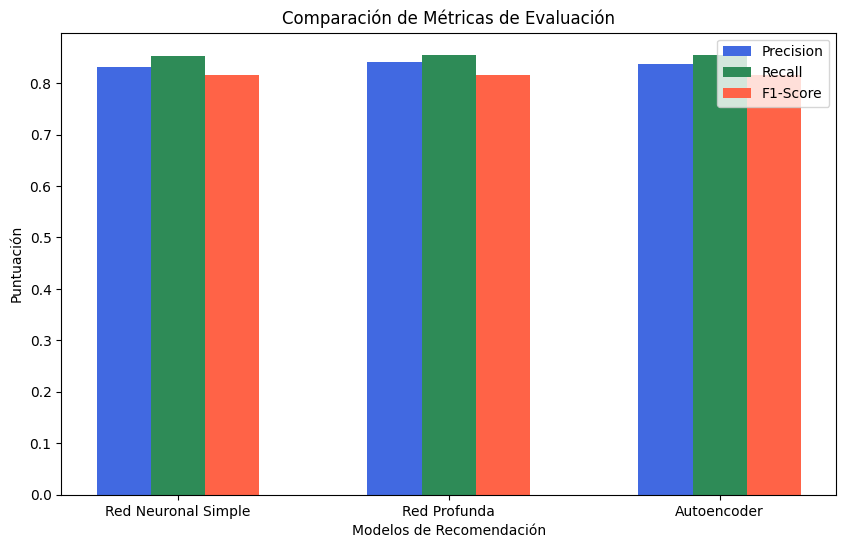

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de las métricas
modelos = ["Red Neuronal Simple", "Red Profunda", "Autoencoder"]
precision_scores = [precision_nn, precision_deep, precision_autoencoder]
recall_scores = [recall_nn, recall_deep, recall_autoencoder]
f1_scores = [f1_nn, f1_deep, f1_autoencoder]

x = np.arange(len(modelos))  # Posiciones en el eje X

# Crear gráfico de barras
plt.figure(figsize=(10,6))
plt.bar(x - 0.2, precision_scores, width=0.2, label="Precision", color='royalblue')
plt.bar(x, recall_scores, width=0.2, label="Recall", color='seagreen')
plt.bar(x + 0.2, f1_scores, width=0.2, label="F1-Score", color='tomato')

plt.xticks(x, modelos)
plt.xlabel("Modelos de Recomendación")
plt.ylabel("Puntuación")
plt.title("Comparación de Métricas de Evaluación")
plt.legend()
plt.show()

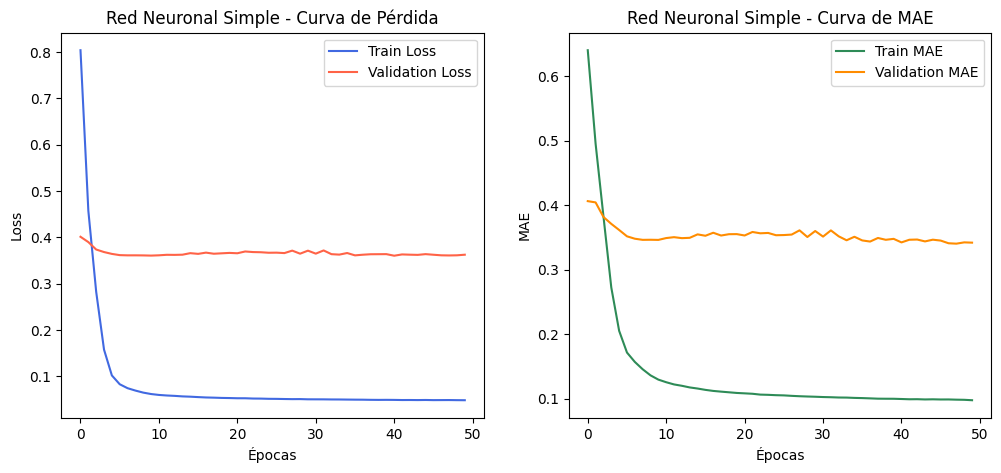

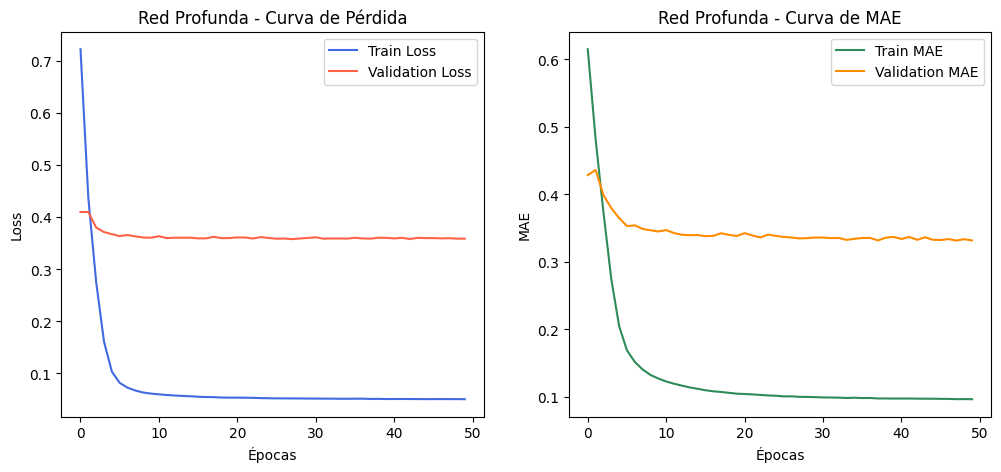

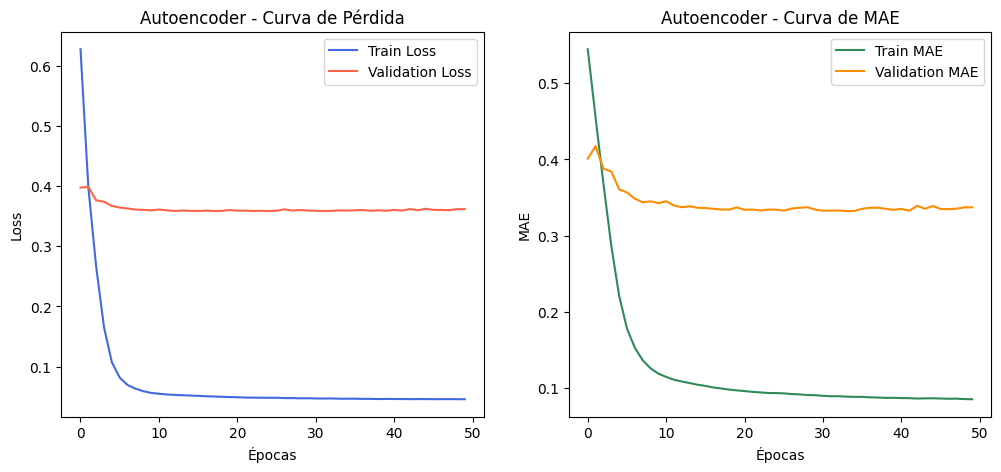

In [17]:
def plot_learning_curves(history, title):
    """
    Grafica la curva de aprendizaje de un modelo.

    Parámetros:
    - history: Historial de entrenamiento de Keras (loss y métricas).
    - title: Título de la gráfica.
    """
    plt.figure(figsize=(12,5))

    # Gráfico de Pérdida
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label="Train Loss", color='royalblue')
    plt.plot(history.history['val_loss'], label="Validation Loss", color='tomato')
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.title(f"{title} - Curva de Pérdida")
    plt.legend()

    # Gráfico de MAE
    plt.subplot(1,2,2)
    plt.plot(history.history['mae'], label="Train MAE", color='seagreen')
    plt.plot(history.history['val_mae'], label="Validation MAE", color='darkorange')
    plt.xlabel("Épocas")
    plt.ylabel("MAE")
    plt.title(f"{title} - Curva de MAE")
    plt.legend()

    plt.show()

# Graficar curvas de aprendizaje para cada modelo
plot_learning_curves(history, "Red Neuronal Simple")
plot_learning_curves(history_deep, "Red Profunda")
plot_learning_curves(history_autoencoder, "Autoencoder")
